In [1]:
%load_ext autoreload
%autoreload 2

In [31]:
import sys
sys.path.insert(0, '../src/')
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.manifold import Isomap
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.base import clone
import matplotlib.pyplot as plt
from pathlib import Path

from preprocessing import BagOfNotes, MidiPathToDataFrame, PreprocessMidiDataFrame, NfIsf, BagOfChords2, Downsampler
import evaluation

In [4]:
data_dir = Path('../maestro/maestro-v3.0.0/')
df = pd.read_csv(data_dir / 'maestro-v3.0.0.csv')
keys = pd.read_csv('../eda/key_review.csv')
df = pd.merge(df, keys, how='left', on='canonical_title')
df.head()

,canonical_composer,canonical_title,split,year,midi_filename,audio_filename,duration,draft_key
0,Alban Berg,Sonata Op. 1,train,2018,2018/MIDI-Unprocessed_Chamber3_MID--AUDIO_10_R...,2018/MIDI-Unprocessed_Chamber3_MID--AUDIO_10_R...,698.661160,NaN
1,Alban Berg,Sonata Op. 1,train,2008,2008/MIDI-Unprocessed_03_R2_2008_01-03_ORIG_MI...,2008/MIDI-Unprocessed_03_R2_2008_01-03_ORIG_MI...,759.518471,NaN
2,Alban Berg,Sonata Op. 1,train,2017,2017/MIDI-Unprocessed_066_PIANO066_MID--AUDIO-...,2017/MIDI-Unprocessed_066_PIANO066_MID--AUDIO-...,464.649433,NaN
3,Alexander Scriabin,"24 Preludes Op. 11, No. 13-24",train,2004,2004/MIDI-Unprocessed_XP_21_R1_2004_01_ORIG_MI...,2004/MIDI-Unprocessed_XP_21_R1_2004_01_ORIG_MI...,872.640588,NaN
4,Alexander Scriabin,"3 Etudes, Op. 65",validation,2006,2006/MIDI-Unprocessed_17_R1_2006_01-06_ORIG_MI...,2006/MIDI-Unprocessed_17_R1_2006_01-06_ORIG_MI...,397.857508,NaN


In [5]:
train = df[df.split == 'train']
validate = df[df.split == 'validation']

In [26]:
print(train.shape)

(962, 8)


In [6]:
do_once = Pipeline([
    ('loader', MidiPathToDataFrame(data_dir)),
    ('cleaner', PreprocessMidiDataFrame()),
])
train_loaded = do_once.transform(train.midi_filename)
val_loaded = do_once.transform(validate.midi_filename)


C:\Users\benkc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
C:\Users\benkc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


In [87]:
vectorizers = [
    ('BoN', BagOfNotes(normalize=False)),
    ('BoNn', BagOfNotes(normalize=True)),
    # ('BoC', Pipeline([('Downsample', Downsampler()), ('BoC', BagOfChords2(time_threshold=30))])),
    ('NfIsf', NfIsf()),
]
reducers = [
    ('PCA2', PCA(2)),
    # ('PCA4', PCA(4)),
    ('Iso2', Isomap(n_neighbors=15, n_components=2)),
    # ('Iso4', Isomap(n_neighbors=15, n_components=4)),
]
clusterers = [
    ('kmeans', KMeans(n_clusters=20, n_init=10, random_state=6740*42)),
    # ('spectral', SpectralClustering())
]
models = {}
for v in vectorizers:
    for r in reducers:
        for c in clusterers:
            p = Pipeline([
                v,
                r,
                c,
            ])
            p = clone(p)
            p.fit(train_loaded)
            clusters = p.predict(val_loaded)
            scores = evaluation.evaluate_clusters(clusters, validate[['canonical_composer', 'draft_key']])
            name = f'{v[0]}-{r[0]}-{c[0]}'
            models[name] = p
            print(name)
            print(scores)
            print('\n')

BoN-PCA2-kmeans
{'canonical_composer': 0.40492505584455923, 'draft_key': 0.5059870545949375}


BoN-Iso2-kmeans
{'canonical_composer': 0.370237517175347, 'draft_key': 0.531383495632468}


BoNn-PCA2-kmeans
{'canonical_composer': 0.495362596313616, 'draft_key': 0.7540061677258609}


BoNn-Iso2-kmeans
{'canonical_composer': 0.4897786537421538, 'draft_key': 0.7732809358422883}


NfIsf-PCA2-kmeans
{'canonical_composer': 0.40963816229175865, 'draft_key': 0.4882165060393342}


NfIsf-Iso2-kmeans
{'canonical_composer': 0.36266749472630244, 'draft_key': 0.48785376245704476}




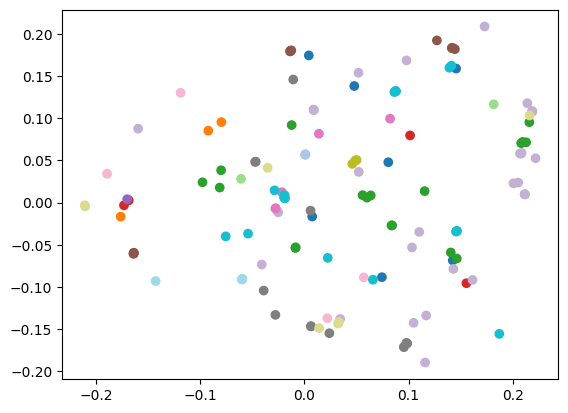

In [88]:
embeddings = models['BoNn-Iso2-kmeans'][:2].transform(val_loaded)
plt.scatter(embeddings[:, 0], embeddings[:, 1], c=validate.canonical_composer.astype("category").cat.codes, cmap='tab20')
plt.show()

In [63]:
validate.canonical_composer.astype("category").cat.categories

Index(['Alexander Scriabin', 'César Franck', 'Felix Mendelssohn',
       'Franz Liszt', 'Franz Liszt / Vladimir Horowitz', 'Franz Schubert',
       'Franz Schubert / Franz Liszt', 'Frédéric Chopin',
       'Johann Sebastian Bach', 'Johannes Brahms', 'Joseph Haydn',
       'Ludwig van Beethoven', 'Mily Balakirev', 'Robert Schumann',
       'Sergei Rachmaninoff', 'Wolfgang Amadeus Mozart'],
      dtype='object')

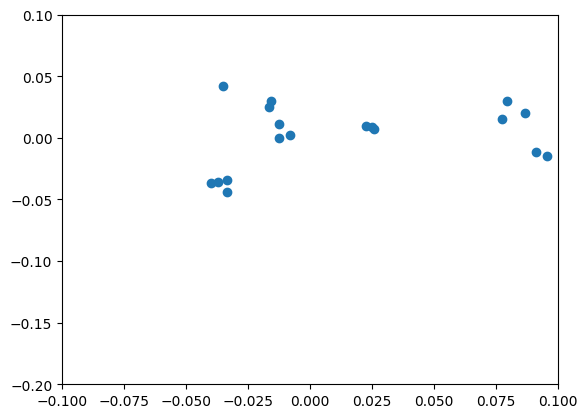

In [84]:
comp = 'Sergei Rachmaninoff'
plt.scatter(embeddings[validate.canonical_composer == comp, 0], embeddings[validate.canonical_composer == comp, 1])
plt.ylim((-.2, .1))
plt.xlim((-.1, .1))
plt.show()

In [86]:
validate[validate.canonical_composer.isin(['Sergei Rachmaninoff', 'Ludwig van Beethoven'])]

,canonical_composer,canonical_title,split,year,midi_filename,audio_filename,duration,draft_key
938,Ludwig van Beethoven,15 Variations and Fugue in Eb on an Original T...,validation,2004,2004/MIDI-Unprocessed_SMF_13_01_2004_01-05_ORI...,2004/MIDI-Unprocessed_SMF_13_01_2004_01-05_ORI...,1402.554623,e flat major
939,Ludwig van Beethoven,"Andante favori in F Major, WoO 57",validation,2018,2018/MIDI-Unprocessed_Chamber6_MID--AUDIO_20_R...,2018/MIDI-Unprocessed_Chamber6_MID--AUDIO_20_R...,524.024583,f major
943,Ludwig van Beethoven,"Eroica Variations, Op. 35",validation,2004,2004/MIDI-Unprocessed_XP_10_R1_2004_01-02_ORIG...,2004/MIDI-Unprocessed_XP_10_R1_2004_01-02_ORIG...,1314.696976,NaN
948,Ludwig van Beethoven,"Sonata No. 11 in B-flat Major, Op. 22, I. Alle...",validation,2015,2015/MIDI-Unprocessed_R1_D1-1-8_mid--AUDIO-fro...,2015/MIDI-Unprocessed_R1_D1-1-8_mid--AUDIO-fro...,336.258333,b flat major
949,Ludwig van Beethoven,"Sonata No. 11 in B-flat Major, Op. 22, I. Alle...",validation,2015,2015/MIDI-Unprocessed_R1_D2-13-20_mid--AUDIO-f...,2015/MIDI-Unprocessed_R1_D2-13-20_mid--AUDIO-f...,318.443750,b flat major
950,Ludwig van Beethoven,"Sonata No. 11 in E-flat Major, Op. 22 (Complete)",validation,2014,2014/MIDI-UNPROCESSED_16-18_R1_2014_MID--AUDIO...,2014/MIDI-UNPROCESSED_16-18_R1_2014_MID--AUDIO...,1320.414011,e flat major
951,Ludwig van Beethoven,"Sonata No. 11, Op. 22 in B-flat Major, I. Alle...",validation,2017,2017/MIDI-Unprocessed_058_PIANO058_MID--AUDIO-...,2017/MIDI-Unprocessed_058_PIANO058_MID--AUDIO-...,321.794363,b flat major
1003,Ludwig van Beethoven,"Sonata No. 27 in E Minor, Op. 90",validation,2018,2018/MIDI-Unprocessed_Recital4_MID--AUDIO_04_R...,2018/MIDI-Unprocessed_Recital4_MID--AUDIO_04_R...,760.277018,e minor
1004,Ludwig van Beethoven,"Sonata No. 27 in E Minor, Op. 90, First Movement",validation,2008,2008/MIDI-Unprocessed_07_R1_2008_01-04_ORIG_MI...,2008/MIDI-Unprocessed_07_R1_2008_01-04_ORIG_MI...,308.536016,e minor
1005,Ludwig van Beethoven,"Sonata No. 27, Op. 90, I. Mit Lebhaftigkeit un...",validation,2017,2017/MIDI-Unprocessed_051_PIANO051_MID--AUDIO-...,2017/MIDI-Unprocessed_051_PIANO051_MID--AUDIO-...,318.420448,NaN


In [ ]:
plt.scatter(embeddings[:, 2], embeddings[:, 3], c=validate.canonical_composer.astype("category").cat.codes, cmap='tab10')
plt.show()

In [47]:
embeddings.shape

(137, 2)

In [48]:
validate.shape

(137, 8)

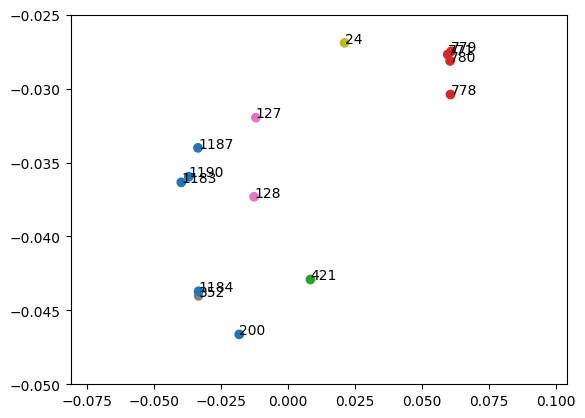

In [52]:
plt.scatter(embeddings[validate.draft_key.notna(), 0], embeddings[validate.draft_key.notna(), 1], c=validate[validate.draft_key.notna()].draft_key.astype("category").cat.codes, cmap='tab10')
for i, id_ in enumerate(validate[validate.draft_key.notna()].index):
    plt.annotate(id_, embeddings[validate.draft_key.notna()][i])
plt.ylim((-0.05, -0.025))
plt.show()

In [53]:
validate.loc[[1184, 352]]

,canonical_composer,canonical_title,split,year,midi_filename,audio_filename,duration,draft_key
1184,Sergei Rachmaninoff,Etude-Tableau Op. 39 No. 6 in A Minor,validation,2017,2017/MIDI-Unprocessed_049_PIANO049_MID--AUDIO-...,2017/MIDI-Unprocessed_049_PIANO049_MID--AUDIO-...,161.913737,a minor
352,Franz Schubert,"Moment Musicaux in F Minor, Op. 94 No. 3",validation,2008,2008/MIDI-Unprocessed_15_R2_2008_01-04_ORIG_MI...,2008/MIDI-Unprocessed_15_R2_2008_01-04_ORIG_MI...,106.156411,f minor


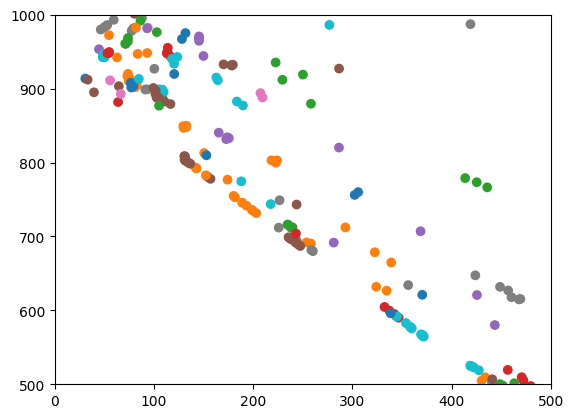

In [12]:
plt.scatter(embeddings[train.draft_key.notna(), 0], embeddings[train.draft_key.notna(), 1], c=train[train.draft_key.notna()].draft_key.astype("category").cat.codes, cmap='tab10')
plt.ylim((500,1000))
plt.xlim((0,500))
plt.show()

In [ ]:
plt.scatter(embeddings[validate.draft_key.notna(), 2], embeddings[validate.draft_key.notna(), 3], c=validate[validate.draft_key.notna()].draft_key.astype("category").cat.codes, cmap='tab10')
plt.show()